# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Некоторые уточнения: 
  - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
  - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
  - Бюджет на разработку скважин в регионе — 10 млрд рублей.
  - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
  - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
  
# Цель исследования:

  1) Изучить исходные данные.\
  2) Обработать данные при необходимости;\
  3) Обучить модель линейной регрессии.\
  4) Рассчитать прибыль по скважинам и предсказаниям.\
  5) Рассчитать прибыль и риски для каждого региона.\
  6) Написание итогового вывода.
  
# Ход исследования:
  
   Данные получим из файлов geo_data_0.csv, geo_data_1.csv, geo_data_2.csv. О качестве данных ничего не известно, поэтому необходимо будет тщательно изучить их.
   
   На этапе предобработки данных найдём все пропущенные значения, обработаем их, удалим явные выбросы, избавимся от дубликатов. После этого исследуем зависимости между параметрами, построим необходимые диаграммы и приступим к обучению модели по прогнозам.
   
   Таким образом, работа состоит из следующих этапов:
   
   - обзор полученных данных;
   - предобработка данных;
   - проведение анализа по конкретным столбцам;
   - обучение моделей линейной регрессии;
   - объяснение закономерностей предсказания модели;
   - рассчитать прибыль и убытки для перспективных районов;
   - написание общего вывода.

In [24]:
# Добавление необходимых библиотек:
import warnings
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import spearmanr

from scipy import stats as st

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error as mse
from math import sqrt

## Загрузка и подготовка данных

### Загрузка данных

Загрузим данные из трёх таблиц, посомтрим на их внешний вид и общую информацию.

In [25]:
# Загрузка данных:
set_0 = pd.read_csv('/datasets/geo_data_0.csv')
set_1 = pd.read_csv('/datasets/geo_data_1.csv')
set_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(set_0.head())
set_0.info()
display(set_1.head())
set_1.info()
display(set_2.head())
set_2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Промежуточный вывод:
Видим, что таблицы равны между собой: в каждой по 5 столбцов и 100000 строк; также не наблюдается пропущенных значений. Типы данных корректны, названия столбцов изменять не нужно.

В особой предобработке данные не нуждаются. Остаётся проверить их на явные и неявные дубликаты.

In [26]:
# Проверка на явные дубликаты:
print('Дубликатов в первой таблице:', set_0.duplicated().sum())
print('Дубликатов во второй таблице:', set_1.duplicated().sum())
print('Дубликатов в третьей таблице:', set_2.duplicated().sum())

Дубликатов в первой таблице: 0
Дубликатов во второй таблице: 0
Дубликатов в третьей таблице: 0


In [27]:
# Проверка на неявные дубликаты:
print('Дубликатов в первой таблице:', set_0['id'].duplicated().sum())
print('Дубликатов во второй таблице:', set_1['id'].duplicated().sum())
print('Дубликатов в третьей таблице:', set_2['id'].duplicated().sum())

Дубликатов в первой таблице: 10
Дубликатов во второй таблице: 4
Дубликатов в третьей таблице: 4


Обнаружено несколько неявных дубликатов, удалим их.

In [28]:
# Смотрим дубликаты:
display(set_0[set_0.duplicated(['id'])])
display(set_1[set_1.duplicated(['id'])])
display(set_2[set_2['id'].duplicated()])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Ничего необычного, просто удаляем их.

In [29]:
# Удаляем дубликаты:
set_0 = set_0.drop_duplicates(['id'])
set_1 = set_1.drop_duplicates(['id'])
set_2 = set_2.drop_duplicates(['id'])

print('Дубликатов в первой таблице:', set_0['id'].duplicated().sum())
print('Дубликатов во второй таблице:', set_1['id'].duplicated().sum())
print('Дубликатов в третьей таблице:', set_2['id'].duplicated().sum())

Дубликатов в первой таблице: 0
Дубликатов во второй таблице: 0
Дубликатов в третьей таблице: 0


Ввиду специфичности данных, вряд ли получится объективно оценить их правдоподобность, однако на распределение данных всё же посмотрим.

Для датафрейма set_0:

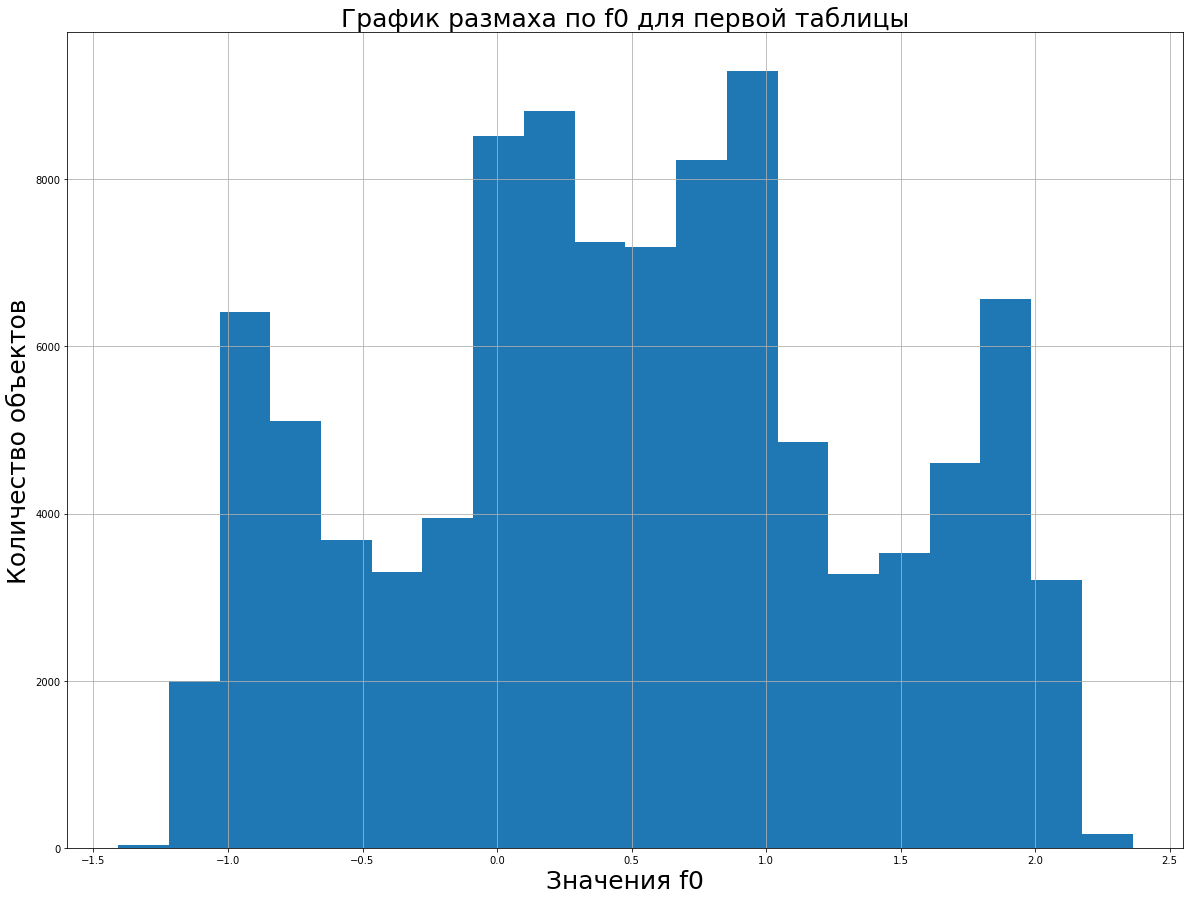

In [30]:
# Гистограмма по f0:
set_0.hist(column='f0', bins=20, figsize=(20, 15))
plt.title('График размаха по f0 для первой таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f0', fontsize=25)
plt.show()

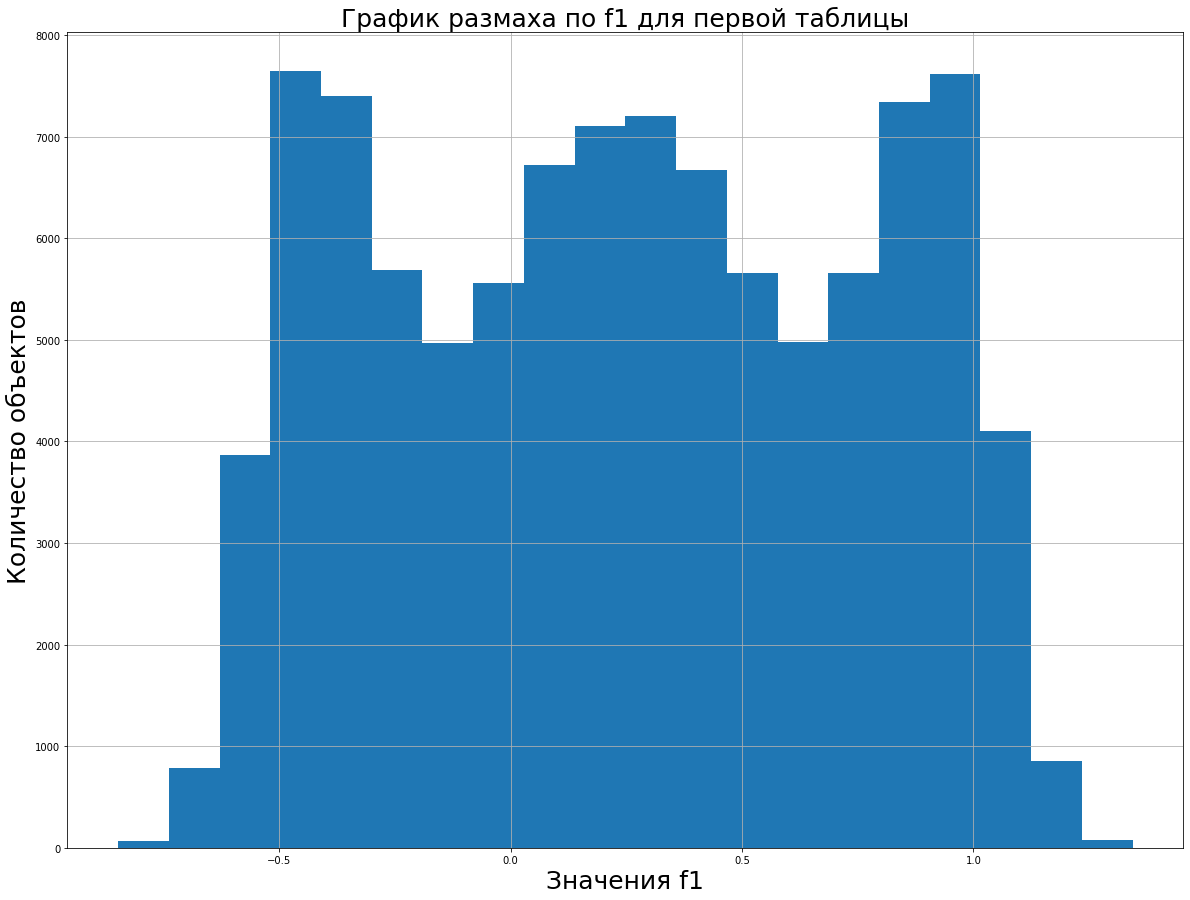

In [31]:
# Гистограмма по f1:
set_0.hist(column='f1', bins=20, figsize=(20, 15))
plt.title('График размаха по f1 для первой таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f1', fontsize=25)
plt.show()

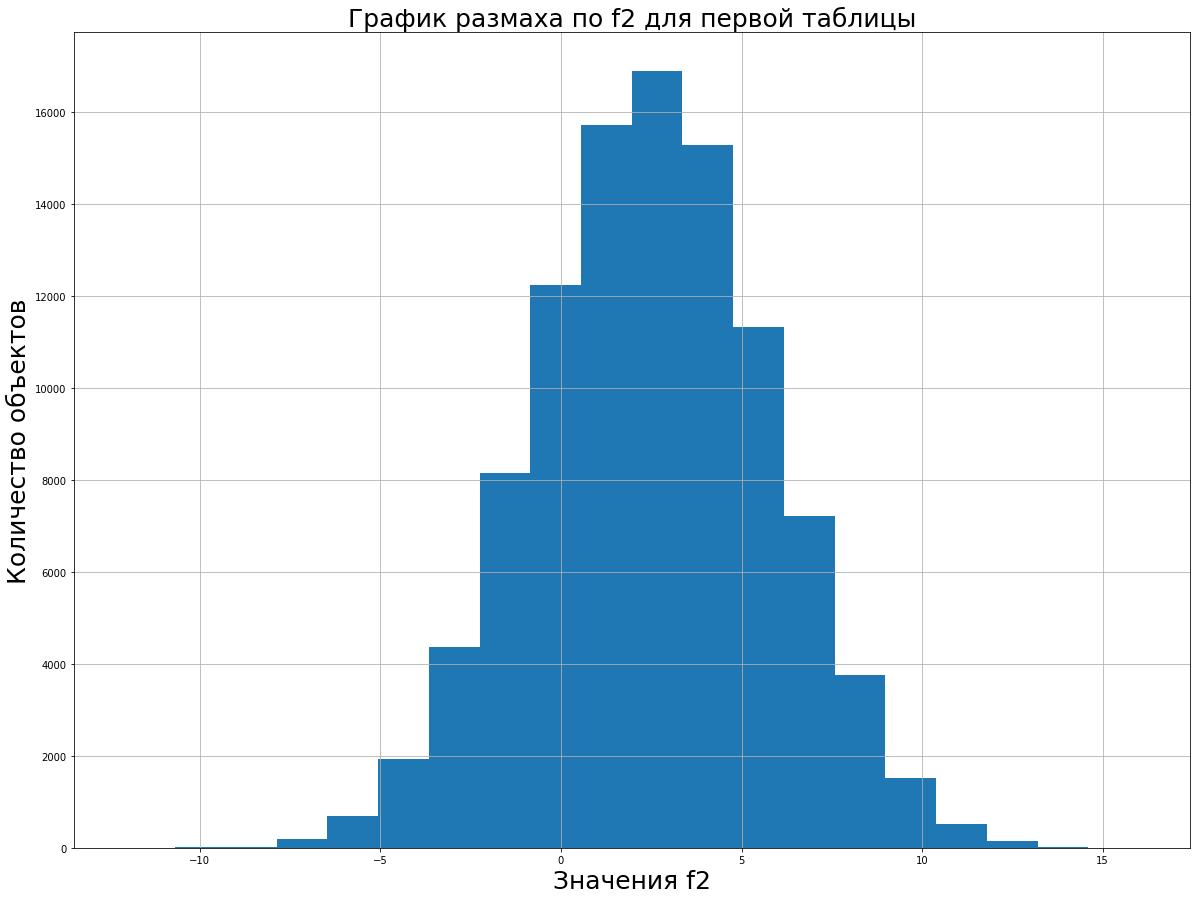

In [32]:
# Гистограмма по f2:
set_0.hist(column='f2', bins=20, figsize=(20, 15))
plt.title('График размаха по f2 для первой таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f2', fontsize=25)
plt.show()

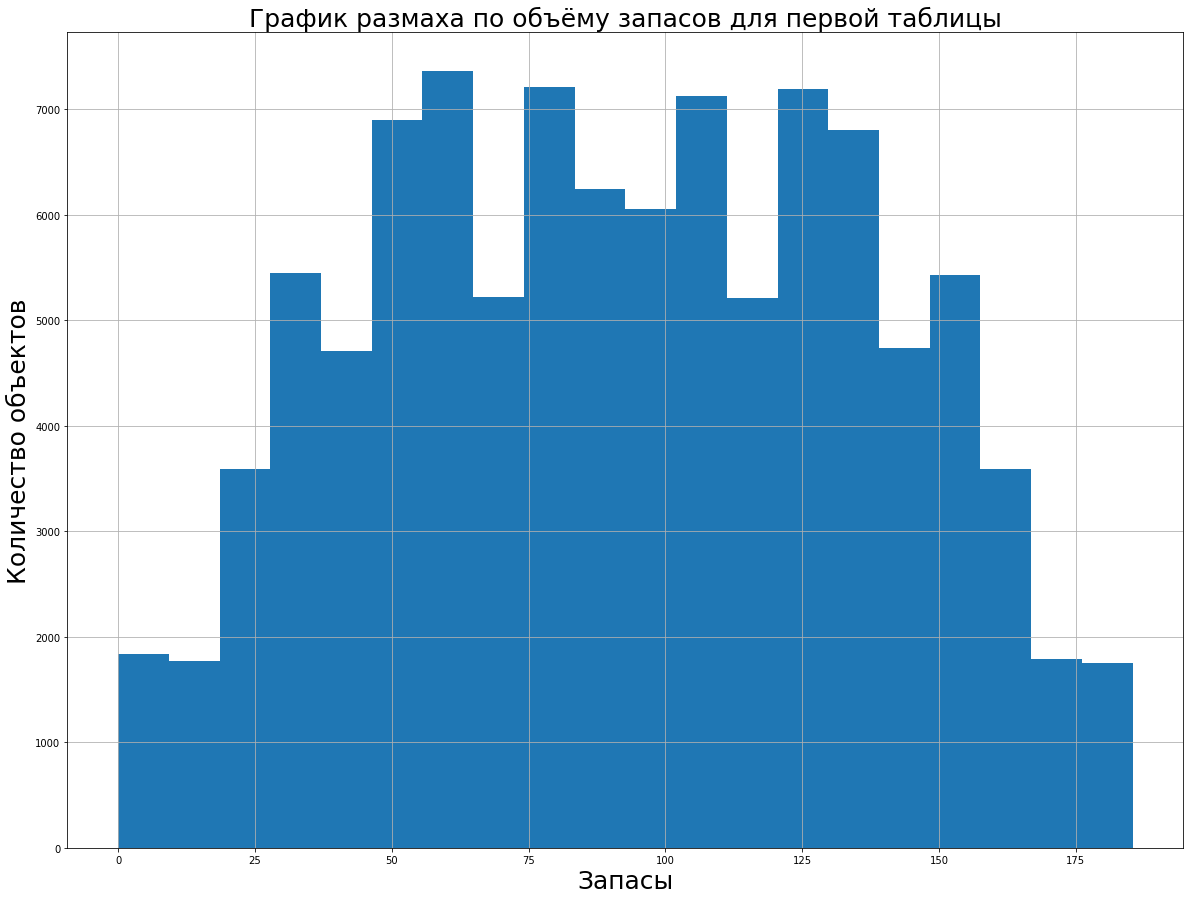

In [33]:
# Гистограмма по product:
set_0.hist(column='product', bins=20, figsize=(20, 15))
plt.title('График размаха по объёму запасов для первой таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Запасы', fontsize=25)
plt.show()

По первой таблице наблюдаем следующую картину: f0 и f1 распредены симметрично относительно своих центров, но нормальными распределениями не являются; f2 классическое нормальное распределение. Запасы распределены симметрично со множеством выбросов.

Для датафрейма set_1:

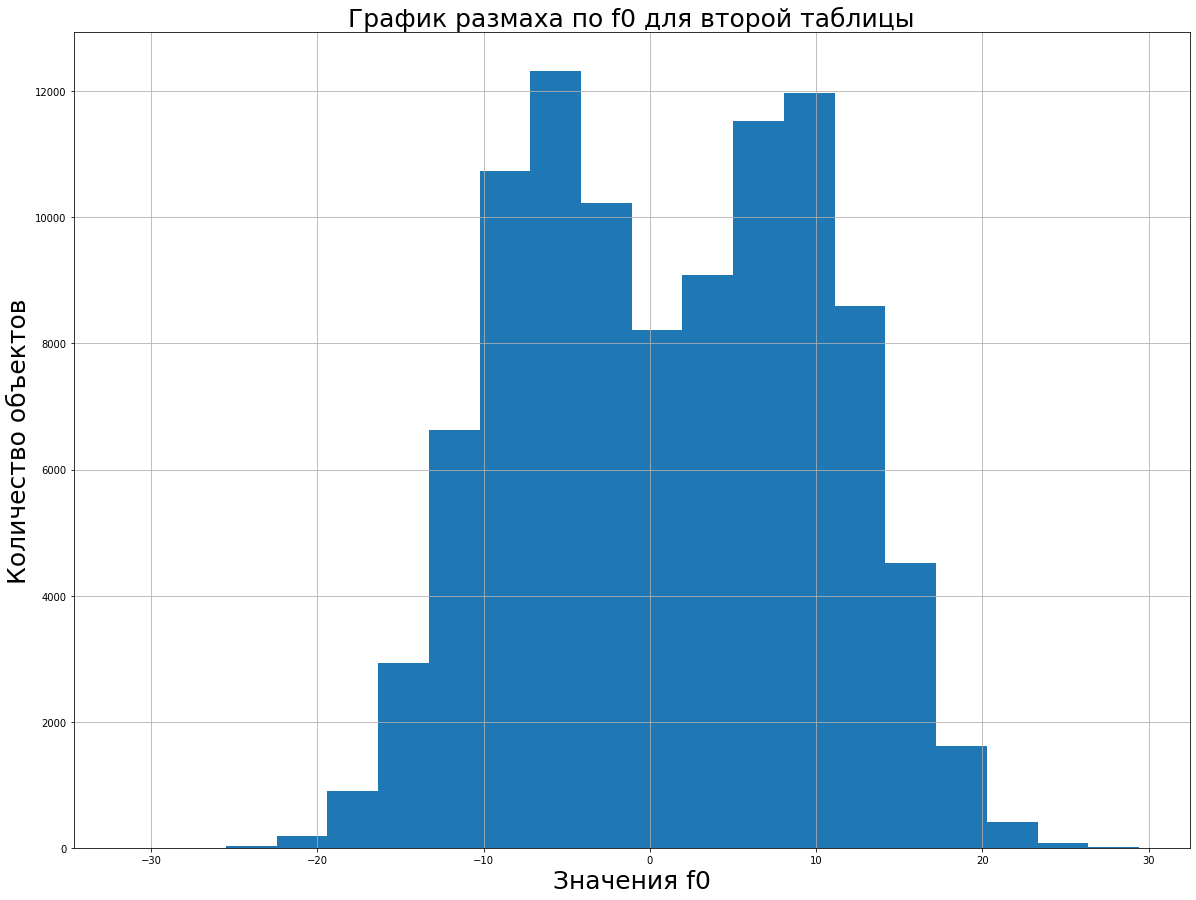

In [34]:
# Гистограмма по f0:
set_1.hist(column='f0', bins=20, figsize=(20, 15))
plt.title('График размаха по f0 для второй таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f0', fontsize=25)
plt.show()

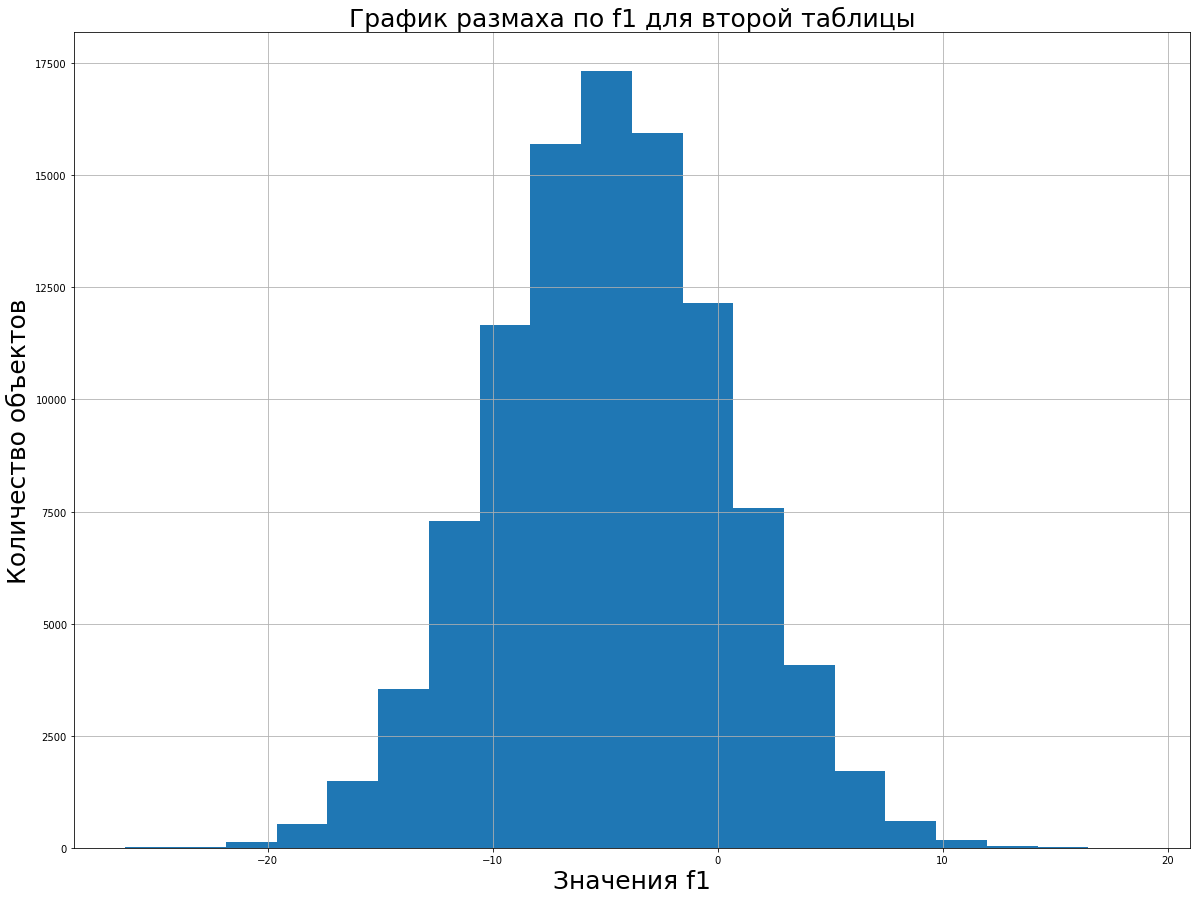

In [35]:
# Гистограмма по f1:
set_1.hist(column='f1', bins=20, figsize=(20, 15))
plt.title('График размаха по f1 для второй таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f1', fontsize=25)
plt.show()

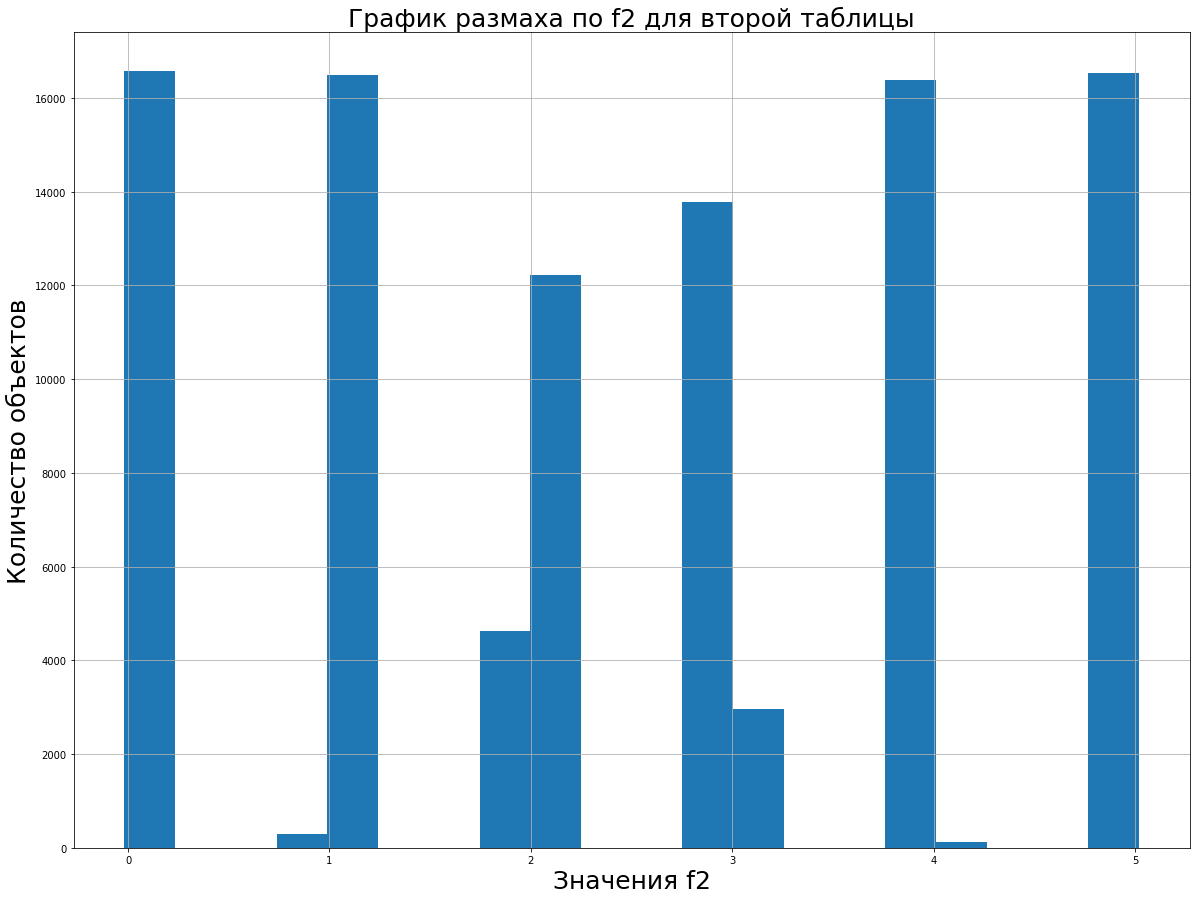

In [36]:
# Гистограмма по f2:
set_1.hist(column='f2', bins=20, figsize=(20, 15))
plt.title('График размаха по f2 для второй таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f2', fontsize=25)
plt.show()

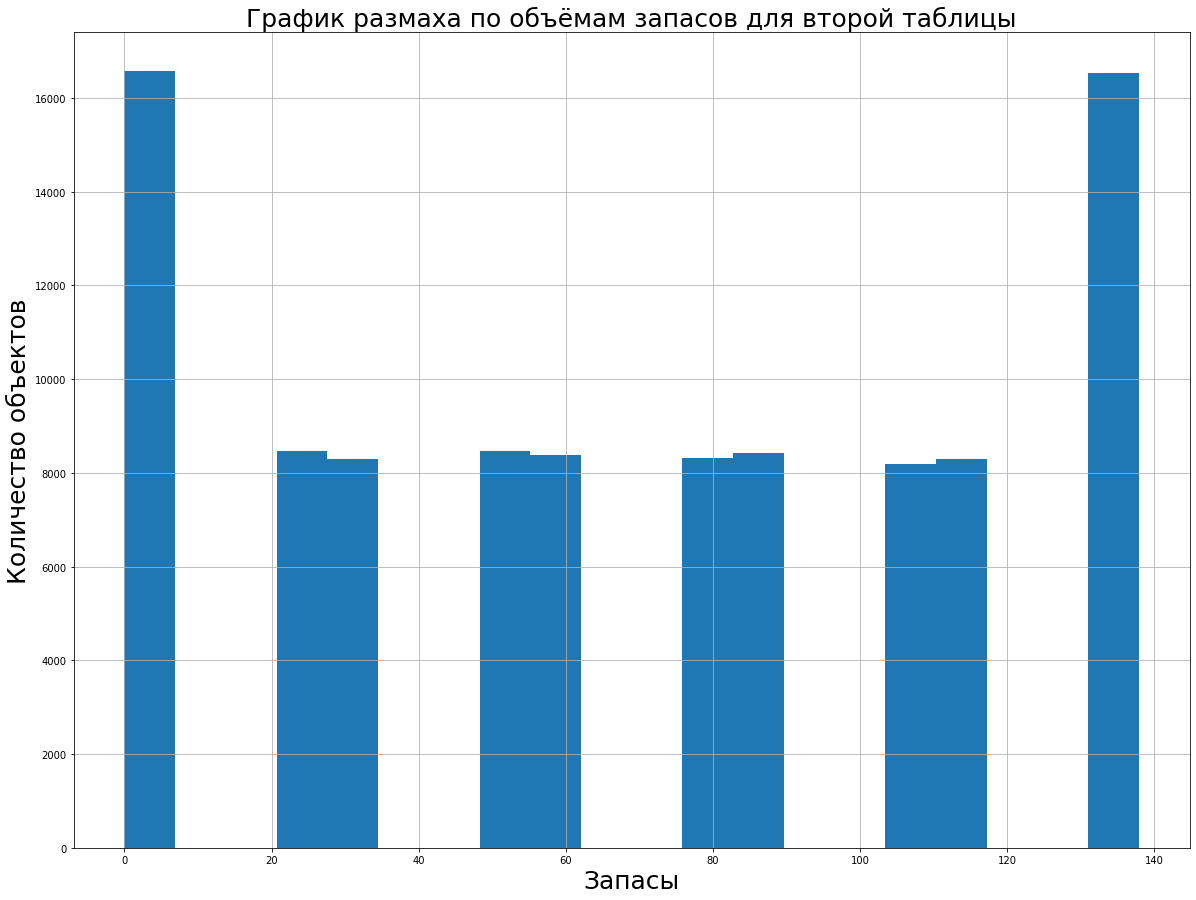

In [37]:
# Гистограмма по product:
set_1.hist(column='product', bins=20, figsize=(20, 15))
plt.title('График размаха по объёмам запасов для второй таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Запасы', fontsize=25)
plt.show()

Со второй таблицей ситуация обратная: нормальное распределение наблюдается у f1, также у f0 распределение напоминает нормальное с некоторыми выбросами, а вот f2 просто распределено вокруг целых чисел. Запасы распределены аналогично f2.

Для датафрейма set_2:

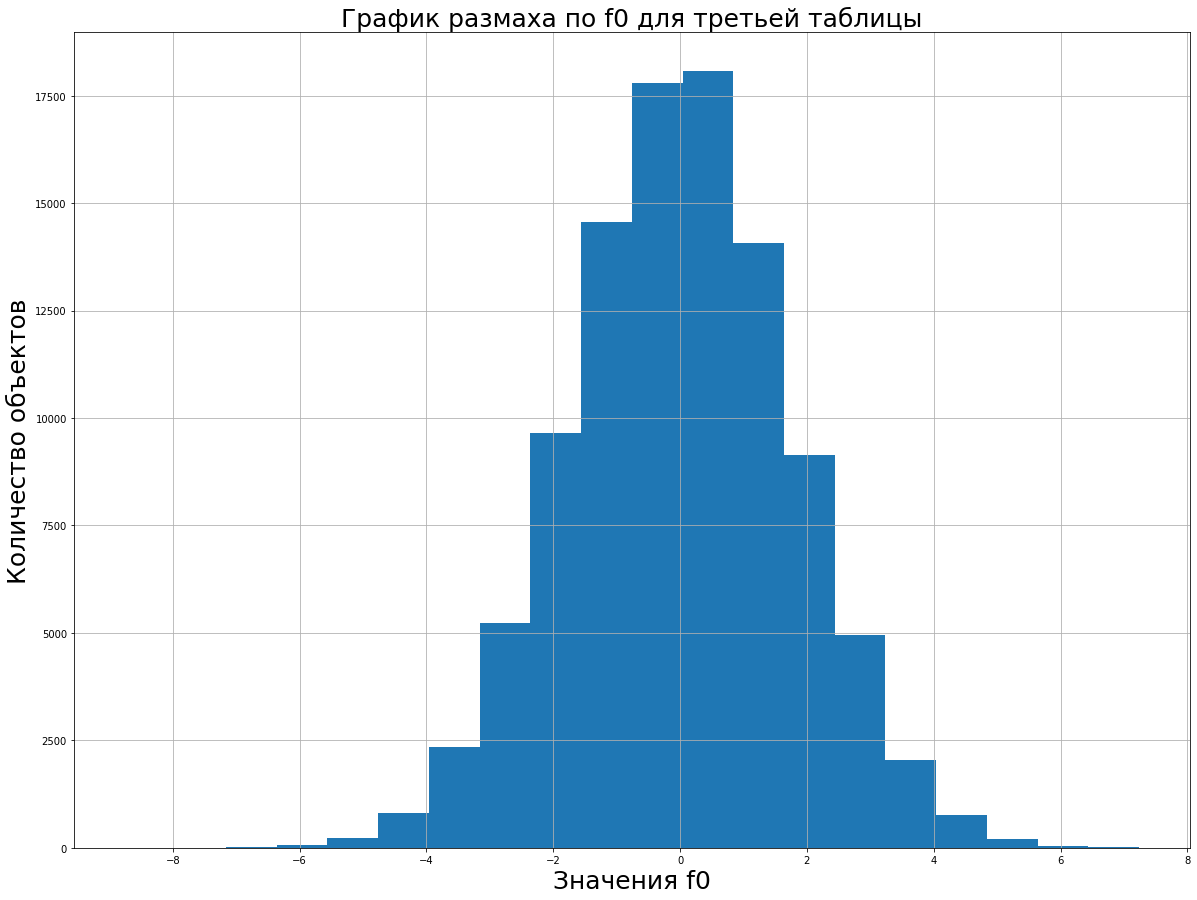

In [38]:
# Гистограмма по f0:
set_2.hist(column='f0', bins=20, figsize=(20, 15))
plt.title('График размаха по f0 для третьей таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f0', fontsize=25)
plt.show()

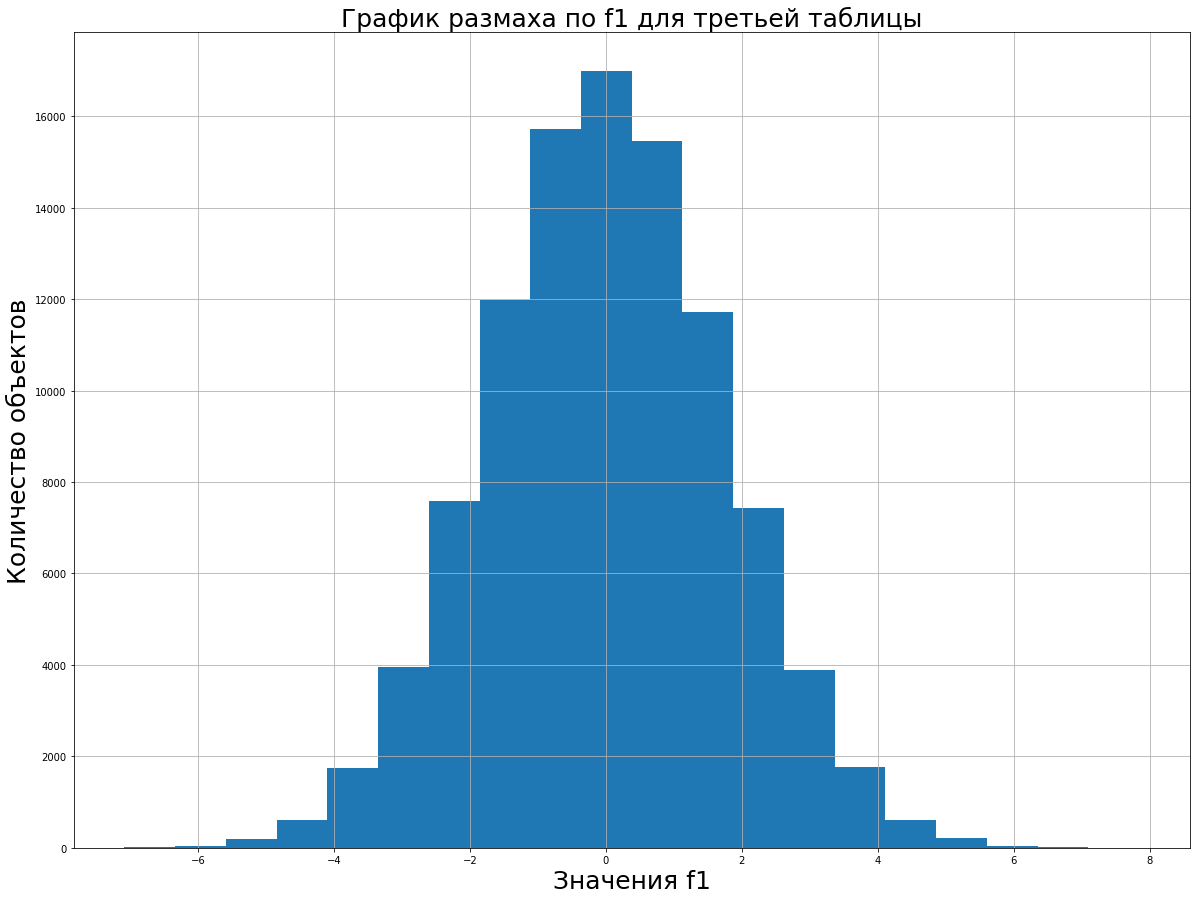

In [39]:
# Гистограмма по f1:
set_2.hist(column='f1', bins=20, figsize=(20, 15))
plt.title('График размаха по f1 для третьей таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f1', fontsize=25)
plt.show()

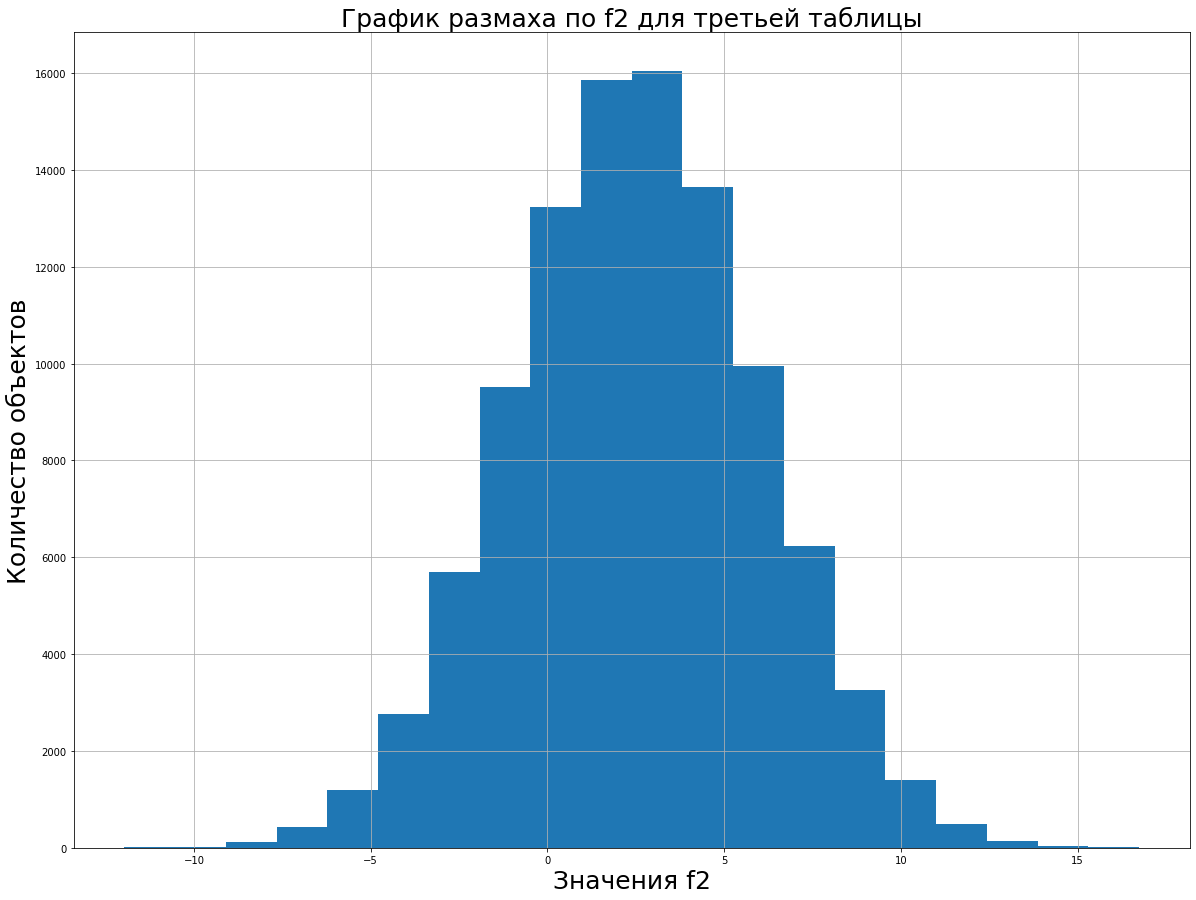

In [40]:
# Гистограмма по f2:
set_2.hist(column='f2', bins=20, figsize=(20, 15))
plt.title('График размаха по f2 для третьей таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Значения f2', fontsize=25)
plt.show()

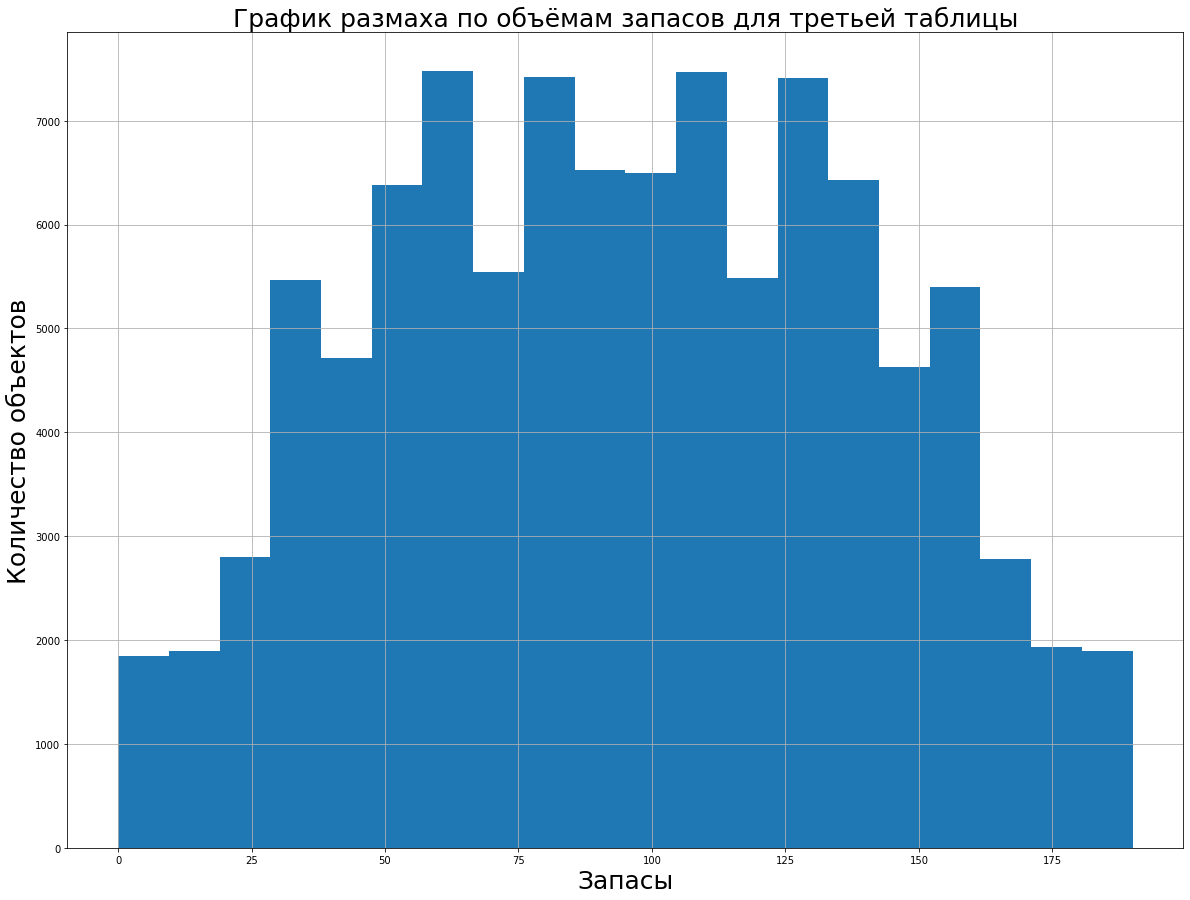

In [41]:
# Гистограмма по product:
set_2.hist(column='product', bins=20, figsize=(20, 15))
plt.title('График размаха по объёмам запасов для третьей таблицы', fontsize=25)
plt.ylabel('Количество объектов', fontsize=25)
plt.xlabel('Запасы', fontsize=25)
plt.show()

В третьей таблице все параметры распределены нормально. Распределение запасов аналогично первой таблице.

### Вывод:
В ходе выполнения этой части работы раскрыли потсупившие данные, обработали неявные дубликаты в них, а также исследовали распределение известных величин.

Данные обработаны в полной мере, можно приступать к их подготовке для обучения модели.

## Обучение и проверка модели

Имеем данные для трёх регионов. Значит, необходимо обучить 3 модели, по 1 на каждый. 

Необходимо разбить каждый сет на тренировочную и валидационную выборки, создать пайплайны для подготовки данных, обучить 3 модели линейной регрессии.

После этого занесём предсказания в таблицы и сравним с исходными данными, посчитаем метрику RMSE.

In [42]:
# Напомним, как выглядят данные:
display(set_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [43]:
# Сделаем id локации новыми индексами:
set_0 = set_0.set_index('id')
set_1 = set_1.set_index('id')
set_2 = set_2.set_index('id')

display(set_0.head())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [44]:
# Задаём константы:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Создаём тренировочную и валидационную выборки:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    set_0.drop('product', axis=1),
    set_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    set_1.drop('product', axis=1),
    set_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = set_1['product'])

X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    set_2.drop('product', axis=1),
    set_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

display(X_train_0.head())
display(y_valid_0.head())

,f0,f1,f2
id,,,
9XrGt,1.986867,-0.143932,3.943780
gFc0c,0.585844,0.686523,-0.599712
TwLv2,1.432727,-0.298195,-1.712253
wMbRo,1.849801,0.164644,-3.638276
cbWaH,1.692548,0.031280,1.413613


id
qoTP6    119.813252
fNYo7    133.296862
KpTZ4     25.310435
vGX0w     65.422491
6N2oA    140.851476
Name: product, dtype: float64

In [45]:
# Список с названиями столбцов:
num_columns = ['f0', 'f1', 'f2']

In [46]:
# Собираем кусок пайплайна для обработки данных:
df_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)], remainder='passthrough')

# Итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', df_preprocessor),
    ('models', LinearRegression())
])

In [47]:
# Перебора моделей:
param_grid_reg = [
    # Словарь для LinearRegression():
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

In [48]:
# Задаём метрику для оценки качества модели:
rmse = make_scorer(mse, greater_is_better=False)

In [49]:
# Обучение первой модели:
grid_search_0 = GridSearchCV(pipe_final, param_grid_reg, cv=2, scoring=rmse, n_jobs=-1)
grid_search_0.fit(X_train_0, y_train_0)

print('Метрика RMSE для лучшей модели:\n', grid_search_0.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search_0.best_estimator_) 

Метрика RMSE для лучшей модели:
 -1421.1693550594218

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])


In [50]:
# Предсказание по валидационной выборке:
y_pred_0 = grid_search_0.predict(X_valid_0)
print(f'Метрика RMSE на валидационной выборке: {sqrt(mse(y_valid_0, y_pred_0))}')

Метрика RMSE на валидационной выборке: 37.68508926201444


In [51]:
# Обучение второй модели:
grid_search_1 = GridSearchCV(pipe_final, param_grid_reg, cv=2, scoring=rmse, n_jobs=-1)
grid_search_1.fit(X_train_1, y_train_1)

print('Метрика RMSE для лучшей модели:\n', grid_search_1.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search_1.best_estimator_) 

Метрика RMSE для лучшей модели:
 -0.7918131746781676

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])


In [52]:
# Предсказание по валидационной выборке:
y_pred_1 = grid_search_1.predict(X_valid_1)
print(f'Метрика RMSE на валидационной выборке: {sqrt(mse(y_valid_1, y_pred_1))}')

Метрика RMSE на валидационной выборке: 0.8920303322677097


In [53]:
# Обучение первой модели:
grid_search_2 = GridSearchCV(pipe_final, param_grid_reg, cv=2, scoring=rmse, n_jobs=-1)
grid_search_2.fit(X_train_2, y_train_2)

print('Метрика RMSE для лучшей модели:\n', grid_search_2.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search_2.best_estimator_) 

Метрика RMSE для лучшей модели:
 -1603.8690415298468

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])


In [54]:
# Предсказание по валидационной выборке:
y_pred_2 = grid_search_2.predict(X_valid_2)
print(f'Метрика RMSE на валидационной выборке: {sqrt(mse(y_valid_2, y_pred_2))}')

Метрика RMSE на валидационной выборке: 40.080822438088305


Модели обучены, предсказания по валидационным выборкам сделаны, посчитаны RMSE каждой модели. Теперь сохраним полученные результаты в таблицах.

In [55]:
# Объединяем валидационную выборку и предсказания в единые таблицы:
set_0_valid = X_valid_0.join(y_valid_0)
set_0_valid['predict'] = y_pred_0
display(set_0_valid.head())

set_1_valid = X_valid_1.join(y_valid_1)
set_1_valid['predict'] = y_pred_1
display(set_1_valid.head())

set_2_valid = X_valid_2.join(y_valid_2)
set_2_valid['predict'] = y_pred_2
display(set_2_valid.head())

,f0,f1,f2,product,predict
id,,,,,
qoTP6,1.760123,0.602091,7.850248,119.813252,127.486528
fNYo7,0.948101,-0.601353,4.055264,133.296862,116.465831
KpTZ4,-0.721709,0.577912,-0.134307,25.310435,66.041910
vGX0w,-0.084550,0.907580,-2.972129,65.422491,45.009390
6N2oA,0.272074,0.818032,8.694180,140.851476,124.535557


,f0,f1,f2,product,predict
id,,,,,
z3sux,-2.871894,-3.636832,2.002760,57.085625,56.125656
ms1Ks,-2.715520,-2.228650,1.002684,30.132364,29.118362
iIQCY,-1.997243,0.169267,5.003981,137.945408,136.803040
cZ9gC,14.833618,-1.460893,2.007172,53.906522,53.632600
6Us0V,12.325100,3.331654,-0.004248,0.000000,-0.320606


,f0,f1,f2,product,predict
id,,,,,
fEtM4,-1.349641,3.092185,5.414776,156.925842,111.540811
ZUTtd,-2.312980,1.702764,-2.386952,31.245818,66.812289
VtpnE,3.021226,-0.322292,-1.739777,48.478519,70.406921
qju6o,0.500312,-1.925757,-3.053501,34.079047,63.118690
FbzYP,-2.202068,2.999640,10.552605,138.077543,141.162178


Вычислим для каждой таблицы средний запас предсказанного и действительного сырья.

In [56]:
# Расчёт средних величин:
mean_0_real = set_0_valid['product'].mean()
mean_0_pred = set_0_valid['predict'].mean()

mean_1_real = set_1_valid['product'].mean()
mean_1_pred = set_1_valid['predict'].mean()

mean_2_real = set_2_valid['product'].mean()
mean_2_pred = set_2_valid['predict'].mean()

print('Для первой таблицы:')
print('Реальное среднее:', mean_0_real)
print('Предсказанное:', mean_0_pred)
print()
print('Для второй таблицы:')
print('Реальное среднее:', mean_1_real)
print('Предсказанное:', mean_1_pred)
print()
print('Для третьей таблицы:')
print('Реальное среднее:', mean_2_real)
print('Предсказанное:', mean_2_pred)

Для первой таблицы:
Реальное среднее: 92.38876593595461
Предсказанное: 92.60984027552017

Для второй таблицы:
Реальное среднее: 68.8233132466615
Предсказанное: 68.82057844409007

Для третьей таблицы:
Реальное среднее: 95.25463671658842
Предсказанное: 94.93478722287514


Получилось достаточно неплохо.

### Вывод:
Провели разделение трёх датасетов на тренировочные и валидационные выборки, создали пайплайн обработки и поиска лучшей модели.

Было обучено 3 модели линейной регрессии (StandardScaler()) и сделаны предсказания на валидационных выборках. Результаты занесены в обновлённые таблицы.

Посчитаны средние значения реальных и предсказанных запасов, расхождение незначительное. Посчитана метрика RMSE для каждой модели: для первой - 37.68, для второй - 0.89, для третьей - 40.08. Разброс немаленький, однако способов дополнить данные у нас нет, поэтому продолжаем работать так.

Изначально наименьшая ошибка в первом регионе. Для лучшего изучения нам потребуется дополнительная информация.

## Подготовка к расчёту прибыли

В данном пункте выполним все необходимые приготовления для дальнейшего расчёта прибыли. Обозначим переменные, рассчитаем безубыточную разработку скважины, сравним результат со средними значениями запасов.

In [57]:
# Зададим значения в переменные:
total = 500  # всего скважин
target = 200  # выборка лучших скважин
budget = 10000000000  # бюджет на разработку
cost = 450000  # цена за единицу продукции
max_prob = .025 # максимальная вероятность риска

In [58]:
# Объём безубыточной разработки:
volume_0 = (budget/cost)/target
print('Объём безубыточной разработки:', f"{volume_0:.0f}")

Объём безубыточной разработки: 111


Как видим, значение получилось значительно больше, чем средние показатели по регионам.

Теперь напишем функцию для подсчёта прибыли по выбранным скважинам и предсказаниям моделей.

In [59]:
# Функция расчёта прибыли:
def profit_cal(df):
    df = df.sort_values(by = 'predict', ascending = False)
    wells = df.head(target)
    profit = (wells['product'].sum() * cost) - budget
    return profit

Теперь посчитаем прибыль для каждого региона.

In [60]:
# Расчёт прибыли по регионам:
print('В первом регионе:', f"{profit_cal(set_0_valid):.0f}")
print('Во втором регионе:', f"{profit_cal(set_1_valid):.0f}")
print('В третьем регионе:', f"{profit_cal(set_2_valid):.0f}")

В первом регионе: 3468529787
Во втором регионе: 2415086697
В третьем регионе: 2396613001


### Вывод:
Выполнена подготовка переменных для дальнейших расчётов. Посчитан объём безубыточной разработки, он оказался выше на 20 пунктов, чем в среднем в первом и третьем регионах, и значительно больше, чем во втором регионе.

Написана функция расчёта приыбли для каждого региона, получены конкретные значения. Больше всего получается по первому региону (3,5 млрд), во втором и третьем практически одинаково (по 2,4 млрд).

## Расчёт прибыли и рисков 

Теперь необходимо посчитать риски и прибыль для каждого региона. Для этого используем методику Bootstrap и найдём распределение прибыли. Также найдём среднюю прибыль, 95-ый доверительный интервал и риск убытков.

In [61]:
# Функция расчета доходов и убытков:
def profit_and_loss(df):
    
    state = np.random.RandomState(42)
    profit_bootstrep = []
    
    for i in range(0, 1000, 1):
        df_sample = df.sample(n=500, replace=True, random_state=state)
        profit_bootstrep.append(profit_cal(df_sample))
    
    profit_bootstrep = pd.Series(profit_bootstrep)

    profit_mean = int(profit_bootstrep.mean()) # Средний доход
    
    lower_profit = int(profit_bootstrep.quantile(.025)) # Нижний квантиль 2.5% от 95% доверительного интервала
    
    upper_profit = int(profit_bootstrep.quantile(.975)) # Верхний квантиль 97.5% от 95% доверительного интервала

    prob_of_loss = (profit_bootstrep.values < 0).mean() # Вероятность убытка
    
    print(f'95% доверительный интервал доходности находится в пределах от {lower_profit} до {upper_profit}')
    print('Средний доход:', profit_mean)
    print(f'Вероятность убытка: {prob_of_loss*100.:0.2}%')
    
    return profit_mean, prob_of_loss

In [62]:
# Подготовим списки для работы функции:
profits_mean = []
prob_of_losses = []

In [63]:
# Для первого региона:
profit_mean, prob_of_loss = profit_and_loss(set_0_valid)
profits_mean.append(profit_mean)
prob_of_losses.append(prob_of_loss)

95% доверительный интервал доходности находится в пределах от -137690003 до 902848310
Средний доход: 403572063
Вероятность убытка: 5.9%


In [64]:
# Для второго региона:
profit_mean, prob_of_loss = profit_and_loss(set_1_valid)
profits_mean.append(profit_mean)
prob_of_losses.append(prob_of_loss)

95% доверительный интервал доходности находится в пределах от 50354780 до 852289453
Средний доход: 445532027
Вероятность убытка: 1.6%


In [65]:
# Для третьего региона:
profit_mean, prob_of_loss = profit_and_loss(set_2_valid)
profits_mean.append(profit_mean)
prob_of_losses.append(prob_of_loss)

95% доверительный интервал доходности находится в пределах от -127589876 до 910134439
Средний доход: 384214428
Вероятность убытка: 8.0%


### Вывод:
С помощью метода Bootstrap составили функцию для нахождения 95% доверительного интервала, среднего дохода и вероятности понести убытки. Для каждого региона рассчитали эти показатели.

Наибольшая вероятность убытка оказалась в третьем регионе (8%), наименьшая - во втором (1,6%). В первом регионе показатель вышел за допустимые рамки (5 > 2.5), поэтому он вместе с третьим не подходят для компании.

Также нам повезло со средним доходом: во втором регионе по итогам рассчётов он оказался наибольшим и составил 445 млн. рублей.

## Итоговый вывод:
Данный проект представлял собой бизнес-задачу и заключался в анализе трёх регионах, расчёте прибыли и убытков, выборе наиболее оптимального региона для бурения.

Общий план работы заключался в следующем:
   - обзор полученных данных;
   - предобработка данных;
   - проведение анализа по конкретным столбцам;
   - обучение моделей линейной регрессии;
   - объяснение закономерностей предсказания модели;
   - рассчитать прибыль и убытки для перспективных районов;
   - написание общего вывода.
  
В результате произведена следующаяя работа:

  1) В ходе первичного анализа потсупивших данных обработали неявные дубликаты в них, а также исследовали распределение известных величин. 
  
  2) Провели разделение трёх датасетов на тренировочные и валидационные выборки, создали пайплайн обработки и поиска лучшей модели.

  3) Было обучено 3 модели линейной регрессии (StandardScaler()) и сделаны предсказания на валидационных выборках. Результаты занесены в обновлённые таблицы.

  4) Посчитаны средние значения реальных и предсказанных запасов, расхождение незначительное. Посчитана метрика RMSE для каждой модели: для первой - 37.68, для второй - 0.89, для третьей - 40.08. Разброс немаленький, однако способов дополнить данные у нас нет, поэтому продолжаем работать так.
  
  5) Выполнена подготовка переменных для дальнейших расчётов. Посчитан объём безубыточной разработки, он оказался выше на 20 пунктов, чем в среднем в первом и третьем регионах, и значительно больше, чем во втором регионе.

  6) Написана функция расчёта приыбли для каждого региона, получены конкретные значения. Больше всего получается по первому региону (3,5 млрд), во втором и третьем практически одинаково (по 2,4 млрд).
  
  7) Выбран лучший регион разработки месторождений.
  
С помощью метода Bootstrap составили функцию для нахождения 95% доверительного интервала, среднего дохода и вероятности понести убытки. Для каждого региона рассчитали эти показатели.

Наибольшая вероятность убытка оказалась в третьем регионе (8%), наименьшая - во втором (1,6%). В первом регионе показатель вышел за допустимые рамки (5 > 2.5), поэтому он вместе с третьим не подходят для компании.

Также нам повезло со средним доходом: во втором регионе по итогам рассчётов он оказался наибольшим и составил 445 млн. рублей.